# IMDB Data Preparation

Author: Sunil Kuruba

## IMDB Data Preparation & Cleaning

The IMDB dataset underwent a structured cleaning and preprocessing pipeline to ensure quality, consistency, and readiness for analysis. Below are the key steps involved:

### 1. Data Loading
- The original CSV file was loaded into a Pandas DataFrame for processing.

### 2. Column Cleaning
- Standardized column names:
  - Trimmed whitespace
  - Converted to lowercase
  - Replaced spaces with underscores (e.g., `Release Date` → `release_date`)

### 3. Data Type Conversion
- Converted key columns to appropriate types:
  - `release_date`: converted to `datetime`
  - `budget`, `revenue`, `runtime`, `vote_average`, `vote_count`: converted to numeric types

### 4. Handling Missing Values
- Dropped rows with missing or invalid `budget` or `revenue`
- Filled missing `runtime` values with the median

### 5. Exploding Multi-Value Fields
- Split and exploded comma-separated fields:
  - `genres` → `genres_list`
  - `top_cast` → `top_cast_list`
  - `keywords` → `keywords_list`

### 6. Text Normalization
- Cleaned string columns:
  - Converted to lowercase
  - Stripped leading/trailing whitespace

### 7. Duplicate Removal
- Removed duplicate rows based on `movie_id` and `title`

### 8. Feature Engineering
- Added `release_year` for temporal analysis
- Created exploded versions of multi-label fields for better grouping and filtering

### 9. Outlier Management (Optional)
- Used visual techniques (e.g., box plots) to assess revenue skew and detect outliers

---

The cleaned dataset was used for generating insights such as revenue trends, genre popularity over time, and box office performance analysis. These transformations ensured the data was robust, analysis-ready, and suitable for visualization tasks.

In [86]:
# Prerequisites
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [87]:
# Load CSV
df = pd.read_csv('tmdb_enriched_movies.csv')

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.columns

Index(['movie_id', 'imdb_id', 'title', 'vote_average', 'vote_count', 'status',
       'release_date', 'budget', 'revenue', 'popularity', 'runtime',
       'language', 'genres', 'production_companies', 'director', 'top_cast',
       'keywords'],
      dtype='object')

In [88]:
df.head()

,movie_id,imdb_id,title,vote_average,vote_count,status,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords
0,27205,tt1375666,Inception,8.369,37309,Released,2010-07-15,160000000,839030630,26.3533,148,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","rescue, mission, dreams, airplane, paris, fran..."
1,157336,tt0816692,Interstellar,8.453,36903,Released,2014-11-05,165000000,746606706,44.7344,169,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Michael Caine","rescue, future, spacecraft, race against time,..."
2,155,tt0468569,The Dark Knight,8.519,33688,Released,2008-07-16,185000000,1004558444,34.4859,152,en,"Drama, Action, Crime, Thriller","Warner Bros. Pictures, Legendary Pictures, Syn...",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart","joker, sadism, chaos, secret identity, crime f..."
3,19995,tt0499549,Avatar,7.588,32126,Released,2009-12-15,237000000,2923706026,32.3911,162,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...",James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver","paraplegic, attachment to nature, culture clas..."
4,24428,tt0848228,The Avengers,7.735,31521,Released,2012-04-25,220000000,1518815515,35.1429,143,en,"Science Fiction, Action, Adventure",Marvel Studios,Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo","new york city, superhero, shield, based on com..."


In [89]:

# Convert data types
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.isna().sum()

movie_id                   0
imdb_id                 2786
title                      0
vote_average               0
vote_count                 0
status                     0
release_date            1154
budget                     0
revenue                    0
popularity                 0
runtime                    0
language                   0
genres                  1116
production_companies    2282
director                1208
top_cast                 919
keywords                3111
dtype: int64

In [90]:

# Handle missing values
df.dropna(subset=['budget', 'revenue'], inplace=True)

# Strip and lowercase text fields
text_cols = ['language', 'genres', 'production_companies', 'top_cast', 'keywords', 'status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

In [91]:

# Split multi-value columns
df['genres_list'] = df['genres'].str.split(', ')
df['top_cast_list'] = df['top_cast'].str.split(', ')
df['keywords_list'] = df['keywords'].str.split(', ')

df[['genres', 'genres_list', 'top_cast', 'top_cast_list', 'keywords', 'keywords_list']].head()

,genres,genres_list,top_cast,top_cast_list,keywords,keywords_list
0,"action, science fiction, adventure","[action, science fiction, adventure]","leonardo dicaprio, joseph gordon-levitt, ken w...","[leonardo dicaprio, joseph gordon-levitt, ken ...","rescue, mission, dreams, airplane, paris, fran...","[rescue, mission, dreams, airplane, paris, fra..."
1,"adventure, drama, science fiction","[adventure, drama, science fiction]","matthew mcconaughey, anne hathaway, michael caine","[matthew mcconaughey, anne hathaway, michael c...","rescue, future, spacecraft, race against time,...","[rescue, future, spacecraft, race against time..."
2,"drama, action, crime, thriller","[drama, action, crime, thriller]","christian bale, heath ledger, aaron eckhart","[christian bale, heath ledger, aaron eckhart]","joker, sadism, chaos, secret identity, crime f...","[joker, sadism, chaos, secret identity, crime ..."
3,"action, adventure, fantasy, science fiction","[action, adventure, fantasy, science fiction]","sam worthington, zoe saldaña, sigourney weaver","[sam worthington, zoe saldaña, sigourney weaver]","paraplegic, attachment to nature, culture clas...","[paraplegic, attachment to nature, culture cla..."
4,"science fiction, action, adventure","[science fiction, action, adventure]","robert downey jr., chris evans, mark ruffalo","[robert downey jr., chris evans, mark ruffalo]","new york city, superhero, shield, based on com...","[new york city, superhero, shield, based on co..."


In [92]:

# Remove duplicates
df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)

# Remove invalid rows
df = df[(df['budget'] >= 0) & (df['revenue'] >= 0) & (df['runtime'] > 0)]

# Remove unwanted columns 
df.drop(['imdb_id', 'status'], axis=1, inplace=True)

# Final preview
df.head()

,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
0,27205,Inception,8.369,37309,2010-07-15,160000000,839030630,26.3533,148,en,"action, science fiction, adventure","legendary pictures, syncopy, warner bros. pict...",Christopher Nolan,"leonardo dicaprio, joseph gordon-levitt, ken w...","rescue, mission, dreams, airplane, paris, fran...","[action, science fiction, adventure]","[leonardo dicaprio, joseph gordon-levitt, ken ...","[rescue, mission, dreams, airplane, paris, fra..."
1,157336,Interstellar,8.453,36903,2014-11-05,165000000,746606706,44.7344,169,en,"adventure, drama, science fiction","legendary pictures, syncopy, lynda obst produc...",Christopher Nolan,"matthew mcconaughey, anne hathaway, michael caine","rescue, future, spacecraft, race against time,...","[adventure, drama, science fiction]","[matthew mcconaughey, anne hathaway, michael c...","[rescue, future, spacecraft, race against time..."
2,155,The Dark Knight,8.519,33688,2008-07-16,185000000,1004558444,34.4859,152,en,"drama, action, crime, thriller","warner bros. pictures, legendary pictures, syn...",Christopher Nolan,"christian bale, heath ledger, aaron eckhart","joker, sadism, chaos, secret identity, crime f...","[drama, action, crime, thriller]","[christian bale, heath ledger, aaron eckhart]","[joker, sadism, chaos, secret identity, crime ..."
3,19995,Avatar,7.588,32126,2009-12-15,237000000,2923706026,32.3911,162,en,"action, adventure, fantasy, science fiction","dune entertainment, lightstorm entertainment, ...",James Cameron,"sam worthington, zoe saldaña, sigourney weaver","paraplegic, attachment to nature, culture clas...","[action, adventure, fantasy, science fiction]","[sam worthington, zoe saldaña, sigourney weaver]","[paraplegic, attachment to nature, culture cla..."
4,24428,The Avengers,7.735,31521,2012-04-25,220000000,1518815515,35.1429,143,en,"science fiction, action, adventure",marvel studios,Joss Whedon,"robert downey jr., chris evans, mark ruffalo","new york city, superhero, shield, based on com...","[science fiction, action, adventure]","[robert downey jr., chris evans, mark ruffalo]","[new york city, superhero, shield, based on co..."


## Exploratory Data Analysis

### Visualization 1 - Budget VS Revenue

This scatter plot visualizes the relationship between a movie’s **budget and revenue**, both plotted on a **logarithmic scale** to accommodate the wide range of values. Each blue dot represents an individual movie, and the red line denotes the **regression trend line**, showing the general direction of the relationship. The plot reveals a **positive correlation**—movies with higher budgets tend to earn higher revenues—but with substantial **variance and outliers**, especially among low-budget films. The pink-shaded area below the trend line highlights movies that **underperformed financially**, generating significantly less revenue than expected based on their budgets. This graph effectively illustrates how while high budgets often lead to higher revenue, success is not guaranteed, and many films fall below profitability expectations.

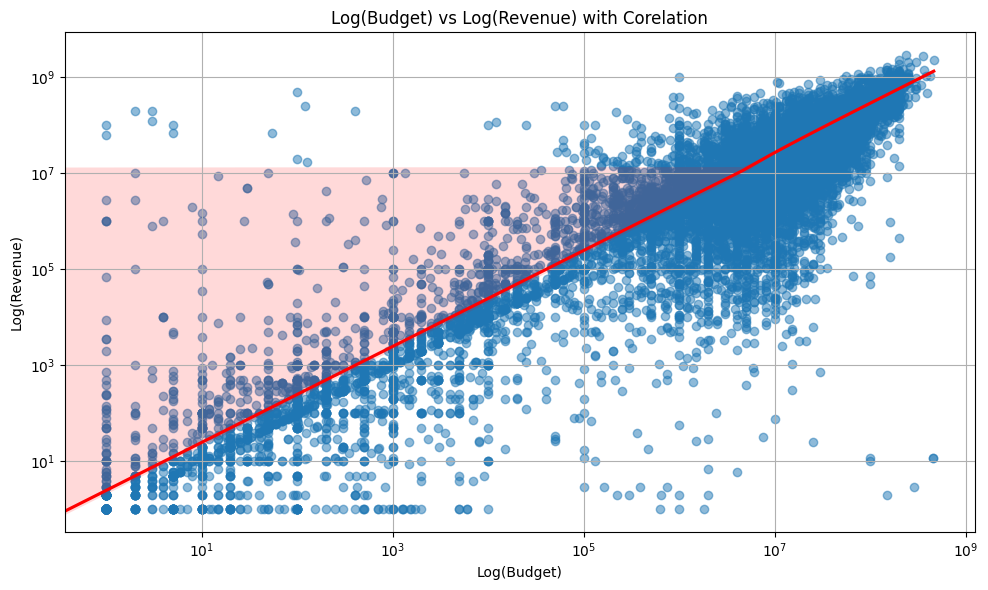

In [93]:
# Scatter plot with regression line
plt.figure(figsize=(10,6))
sns.regplot(
    x='budget',
    y='revenue',
    data=df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(Budget)')
plt.ylabel('Log(Revenue)')
plt.title('Log(Budget) vs Log(Revenue) with Corelation')
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualization 2 - Top 10 Genres by Average Revenue

This bar chart displays the **top 10 movie genres ranked by their average revenue**, providing insight into which genres tend to generate the most box office success. The Y-axis uses a **logarithmic scale**, and a legend is included to help interpret values such as \(10^7 = 10\) million, \(10^8 = 100\) million, and \(10^9 = 1\) billion dollars. Among the genres, **Adventure** leads with the highest average revenue, followed closely by **Animation**, **Science Fiction**, and **Fantasy**, indicating strong commercial performance for visually immersive and franchise-driven content. Genres like **Thriller**, **Comedy**, **War**, and **Crime** appear on the lower end of the chart, suggesting they generally yield lower average returns. This graph effectively highlights genre profitability, reinforcing that high-budget, high-concept genres dominate the global box office.

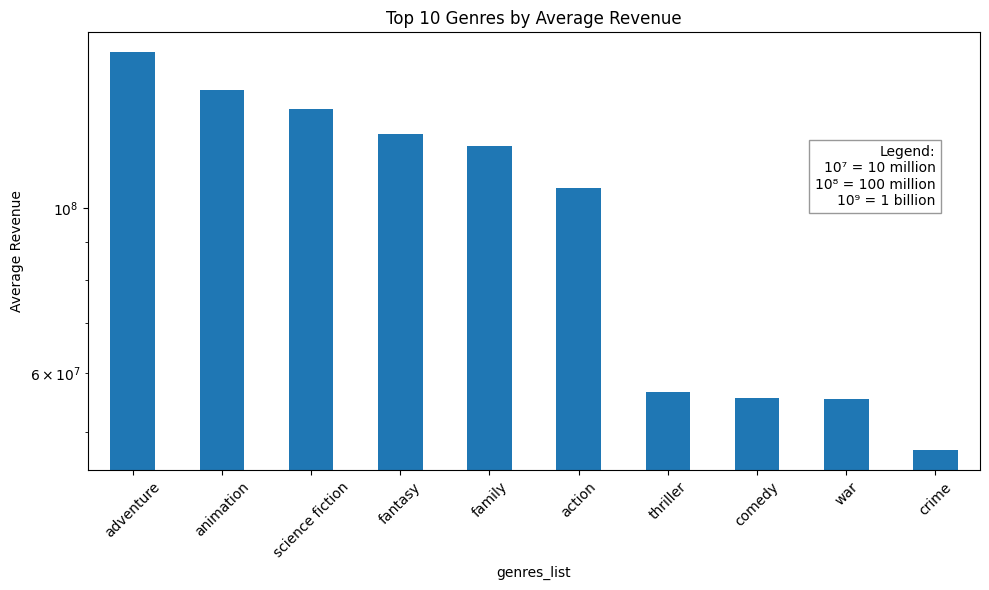

In [94]:
# Explode genre lists
genre_revenue = df.explode('genres_list')
genre_avg_revenue = genre_revenue.groupby('genres_list')['revenue'].mean().sort_values(ascending=False).head(10)

genre_avg_revenue.plot(kind='bar', figsize=(10,6), title='Top 10 Genres by Average Revenue')
plt.yscale('log')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)

plt.text(
    x=9, y=1e8, 
    s='Legend:\n10⁷ = 10 million\n10⁸ = 100 million\n10⁹ = 1 billion',
    fontsize=10,
    ha='right',
    va='bottom',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()


### Visualization 3 - Number of Movies Released and Total Revenue Per year

These side-by-side line plots depict the impact of the COVID-19 pandemic on the global film industry. The **left plot** shows the number of movies released each year, while the **right plot** displays the total revenue generated annually. Both charts demonstrate a steady growth trajectory from the mid-20th century, peaking around **2018–2019**. However, the vertical red dashed line at **2019**, annotated with **“COVID-19”**, highlights a pivotal moment. Post-2019, both metrics exhibit a **dramatic decline**, reflecting the widespread disruptions caused by the pandemic, including halted productions, theater closures, and reduced box office activity. These visuals clearly illustrate how COVID-19 triggered a major downturn in movie releases and earnings after decades of consistent industry growth.

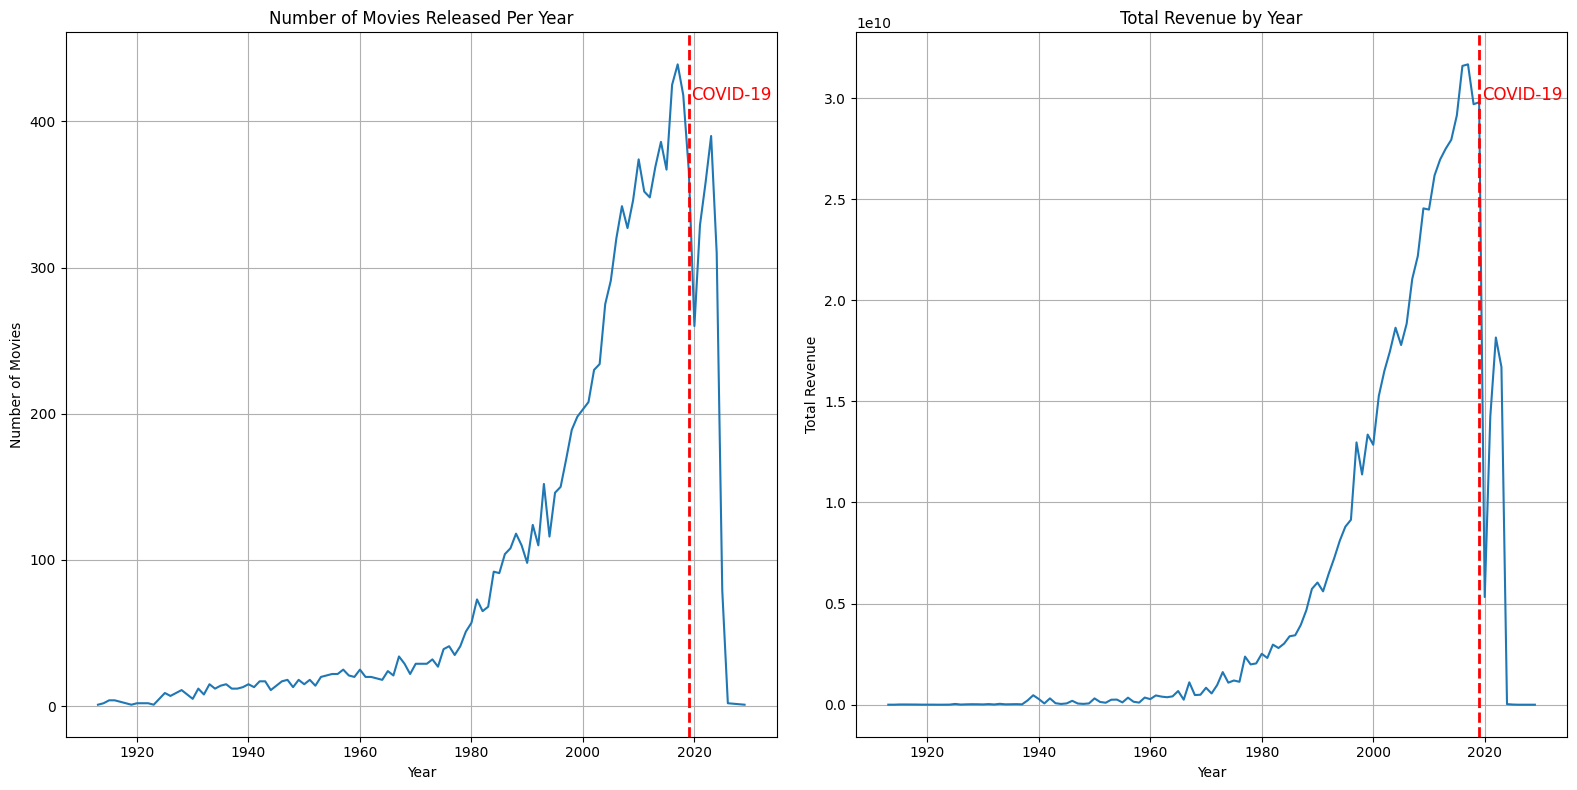

In [95]:

df['release_year'] = df['release_date'].dt.year

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot 1: Number of Movies Released
df['release_year'].value_counts().sort_index().plot(ax=axes[0], title='Number of Movies Released Per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Movies')
axes[0].grid(True)

# Add vertical line for 2019
axes[0].axvline(x=2019, color='red', linestyle='--', linewidth=2)
axes[0].text(2019 + 0.5, axes[0].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=12)

# Plot 2: Total Revenue by Year
df.groupby('release_year')['revenue'].sum().plot(ax=axes[1], title='Total Revenue by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Revenue')
axes[1].grid(True)

# Add vertical line and label
axes[1].axvline(x=2019, color='red', linestyle='--', linewidth=2)
axes[1].text(2019 + 0.5, axes[1].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


### Visualization 4 - Revenue Distribution by Genre

This box plot visualizes the **distribution of movie revenues** across six popular genres: Action, Adventure, Drama, Thriller, Comedy, and Romance. The Y-axis is on a **logarithmic scale**, capturing a wide range of revenue values and helping to identify patterns and outliers. Each box shows the **interquartile range (IQR)**, with the horizontal line inside representing the **median revenue**. Notably, **Adventure and Action** genres exhibit higher median revenues compared to others, suggesting stronger box office performance on average. All genres display a substantial number of **outliers**, indicating that while most films earn within a certain range, a few achieve exceptional financial success. This visualization highlights both the central tendencies and the variability in revenue performance across different movie genres.

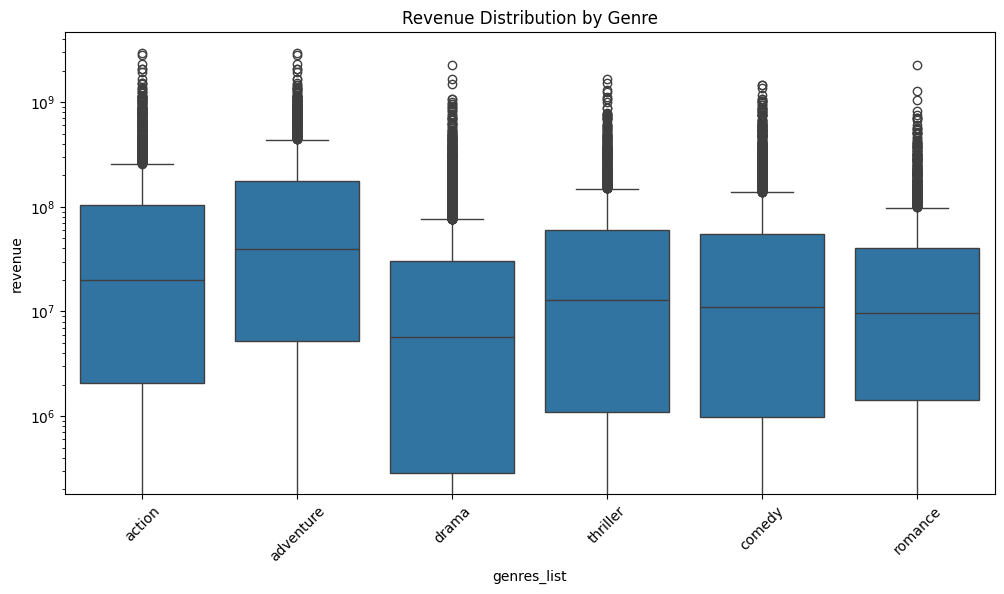

In [96]:

popular_genres = df.explode('genres_list')
popular_genres = popular_genres[popular_genres['genres_list'].isin(
    popular_genres['genres_list'].value_counts().head(6).index)]

plt.figure(figsize=(12,6))
sns.boxplot(x='genres_list', y='revenue', data=popular_genres)
plt.yscale('log')
plt.title('Revenue Distribution by Genre')
plt.xticks(rotation=45)
plt.show()


### Visualization 5 - Genre Trend Over the Years

From the plot, we observe that Drama has consistently been the most released genre, peaking around 2015–2019 with over 200 films per year. Comedy and Thriller also show strong upward trends, especially from the 1980s onward. Action and Adventure genres saw significant growth in the 2000s and 2010s, aligning with the rise of blockbuster cinema. Romance maintained steady popularity but started declining in the late 2010s. There is a sharp drop in all genres after 2019, clearly indicating the impact of the COVID-19 pandemic on film production globally

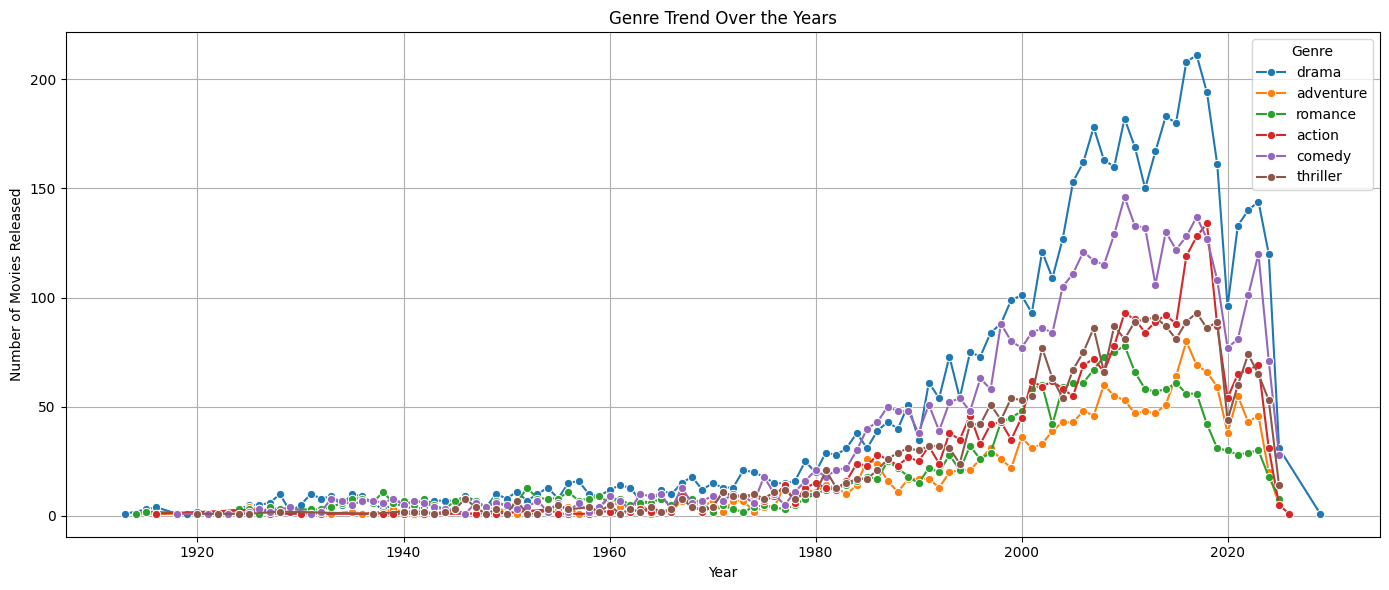

In [97]:

df['release_year'] = df['release_date'].dt.year
df_exploded = df.explode('genres_list')

# Filter to include only popular genres (optional)
top_genres = df_exploded['genres_list'].value_counts().head(6).index
df_filtered = df_exploded[df_exploded['genres_list'].isin(top_genres)]

# Group by year and genre to count number of movies
genre_trend = df_filtered.groupby(['release_year', 'genres_list']).size().reset_index(name='movie_count')

# Plot the trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=genre_trend, x='release_year', y='movie_count', hue='genres_list', marker='o')

plt.title('Genre Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(True)
plt.legend(title='Genre')
plt.tight_layout()
plt.show()


###  Visualization 6 - Profit vs Loss by Genre

This graph presents a comparative view of **genre-wise loss and profit rates** in the film industry. The **left plot** illustrates the proportion of movies that incurred a **loss** in each genre, with *History*, *Western*, and *War* genres topping the list—indicating that a significant share of films in these categories failed to recover their budget. On the **right plot**, we see the **profit rate** for each genre, with *Family*, *Adventure*, and *Action* films showing the highest probability of turning a profit. Interestingly, genres like *Documentary*, *TV Movie*, and *History* consistently appear at the lower end of the profit spectrum and higher end of the loss spectrum, suggesting these may be riskier investments from a financial perspective. This side-by-side visualization clearly demonstrates how profitability varies by genre and can guide production or investment decisions.

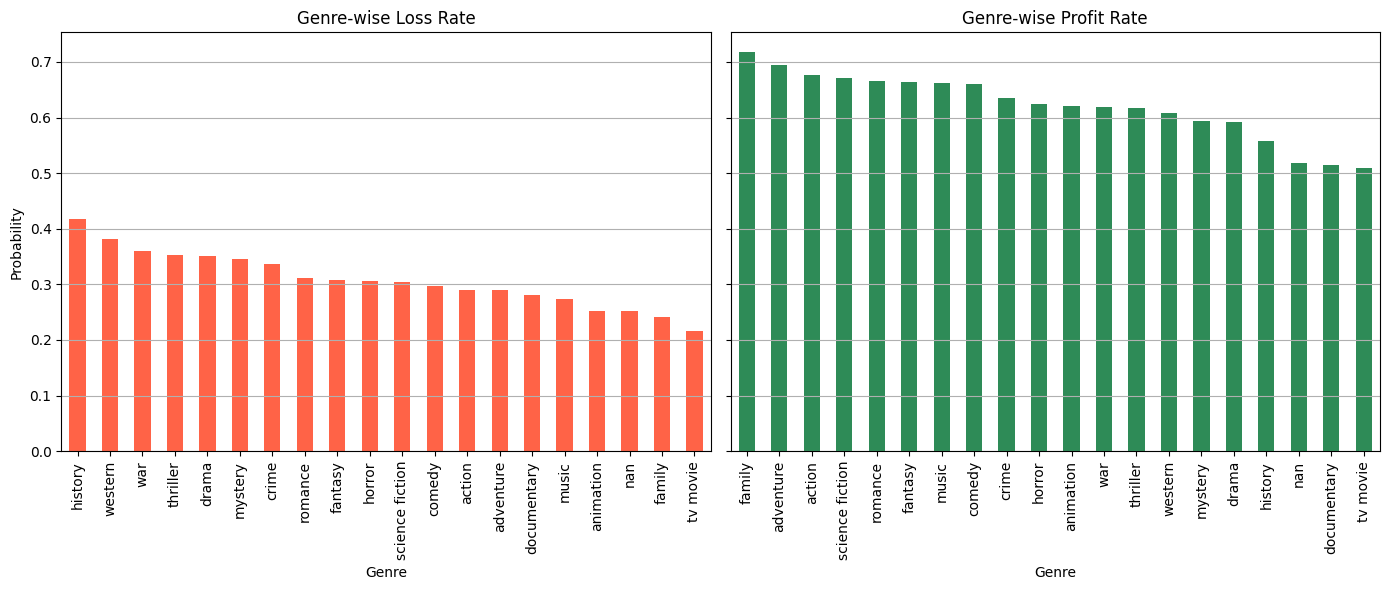

In [98]:

# Calculate profit
df['profit'] = df['revenue'] - df['budget']

# Explode genres into individual rows
df_exploded = df.explode('genres_list')

# Create loss and profit flags
df_exploded['is_loss'] = df_exploded['profit'] < 0
df_exploded['is_profit'] = df_exploded['profit'] > 0

# Calculate percentage loss and profit per genre
loss_rate = df_exploded.groupby('genres_list')['is_loss'].mean()
profit_rate = df_exploded.groupby('genres_list')['is_profit'].mean()

# Combine both into one DataFrame
rate_df = pd.DataFrame({
    'Loss Rate': loss_rate,
    'Profit Rate': profit_rate
})

rate_df_loss = rate_df.sort_values('Loss Rate', ascending=False)
rate_df_profit = rate_df.sort_values('Profit Rate', ascending=False)

# Plot side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Loss plot
rate_df_loss['Loss Rate'].plot(kind='bar', ax=axes[0], color='tomato')
axes[0].set_title('Genre-wise Loss Rate')
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Genre')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

# Profit plot
rate_df_profit['Profit Rate'].plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Genre-wise Profit Rate')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


###  Visualization 7 -  top 20 actors on average revenue-to-budget ratio

From the plot, we can see Robert Shaw, Lin Shaye, and Shawnee Smith stand out with high average revenues, indicating that the movies they participated in typically generated substantial returns compared to their budgets. Olivia de Havilland and Clark Gable also show strong positive returns on relatively modest budgets. Several actors in the lower-left corner (e.g., Margaret Hamilton, Steve Landesberg) had low average budgets and revenues, suggesting lower overall commercial impact, but they still made the top 20 due to high revenue-to-budget efficiency in smaller productions.

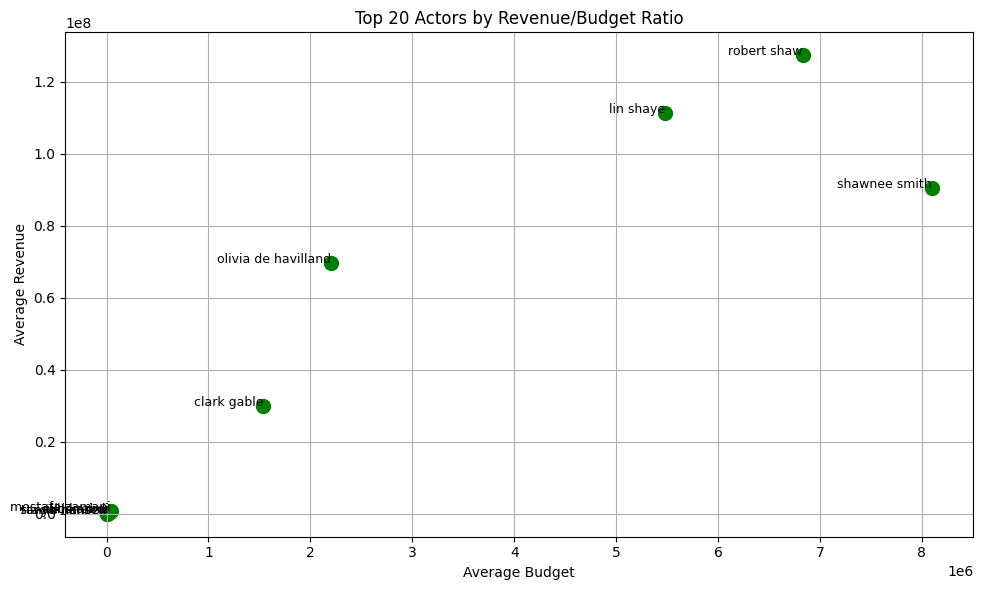

In [99]:

# Explode top_cast_list
df_exploded = df.explode('top_cast_list')

actor_avg = df_exploded.groupby('top_cast_list').agg(
    avg_budget=('budget', 'mean'),
    avg_revenue=('revenue', 'mean'),
    movie_count=('budget', 'count')
)

# Filter to only actors with 5+ movies to avoid outliers
actor_avg = actor_avg[actor_avg['movie_count'] >= 5]

actor_avg['ratio'] = actor_avg['avg_revenue'] / actor_avg['avg_budget']
top10 = actor_avg.sort_values('ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.scatter(top10['avg_budget'], top10['avg_revenue'], color='green', s=100)

for actor, row in top10.iterrows():
    plt.text(row['avg_budget'], row['avg_revenue'], actor, fontsize=9, ha='right')

plt.xlabel('Average Budget')
plt.ylabel('Average Revenue')
plt.title('Top 20 Actors by Revenue/Budget Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()
